In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import numpy as np
from rtc_seq_dataset import SeqDistDataset, open_rtc_table, open_patch_table
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch

In [58]:
seed = torch.Generator().manual_seed(42)

In [3]:
%%time

df_patch = open_patch_table()
df_rtc = open_rtc_table()

CPU times: user 17.1 s, sys: 1.24 s, total: 18.3 s
Wall time: 18.9 s


In [24]:
%%time

seq_dataset = SeqDistDataset(download=False, 
                         n_pre_imgs=4, 
                         patch_table=df_patch, 
                         rtc_table=df_rtc)
for i, data in enumerate(seq_dataset):
    break

# data

tv for vh: 100%|████████████████████████| 5/5 [00:00<00:00, 57.00it/s]

CPU times: user 4.09 s, sys: 1.82 s, total: 5.91 s
Wall time: 11.6 s


In [85]:
def custom_collate_fn(batch):
    pre_imgs_l = [item['pre_imgs'] for item in batch]
    pre_imgs_b = torch.stack(pre_imgs_l, dim=0).float()

    post_img_l = [item['post_img'] for item in batch]
    post_img_b = torch.stack(post_img_l, dim=0).float()
    
    pre_dts = list([item['pre_dts'] for item in batch])

    return {'pre_imgs': pre_imgs_b,
            'post_img': post_img_b,
            'pre_dts': pre_dts}

In [89]:
%%time

train_dataset, val_dataset, test_dataset = random_split(seq_dataset, [.6, .2, .2], generator=seed)

CPU times: user 19.1 s, sys: 12.3 s, total: 31.4 s
Wall time: 33.6 s


In [90]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)


In [91]:
%%time
dl = iter(train_dataloader)

CPU times: user 149 μs, sys: 262 μs, total: 411 μs
Wall time: 326 μs


In [92]:
%%time
batch = next(dl)

tv for vh: 100%|████████████████████████| 5/5 [00:00<00:00, 38.78it/s]


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [39]:
%%time

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)


CPU times: user 170 μs, sys: 216 μs, total: 386 μs
Wall time: 955 μs


In [63]:
%%time
dl = iter(train_dataloader)

CPU times: user 192 μs, sys: 221 μs, total: 413 μs
Wall time: 324 μs


The first next takes longest - not sure what the bottleneck is at initialization.

In [64]:
%%time
batch = next(dl)

tv for vh: 100%|████████████████████████| 5/5 [00:00<00:00, 56.27it/s]


TypeError: list indices must be integers or slices, not str

In [ ]:
batch['pre_dts']

In [30]:
%%time
pre_imgs = batch['pre_imgs'].cpu().numpy()

CPU times: user 128 μs, sys: 228 μs, total: 356 μs
Wall time: 758 μs


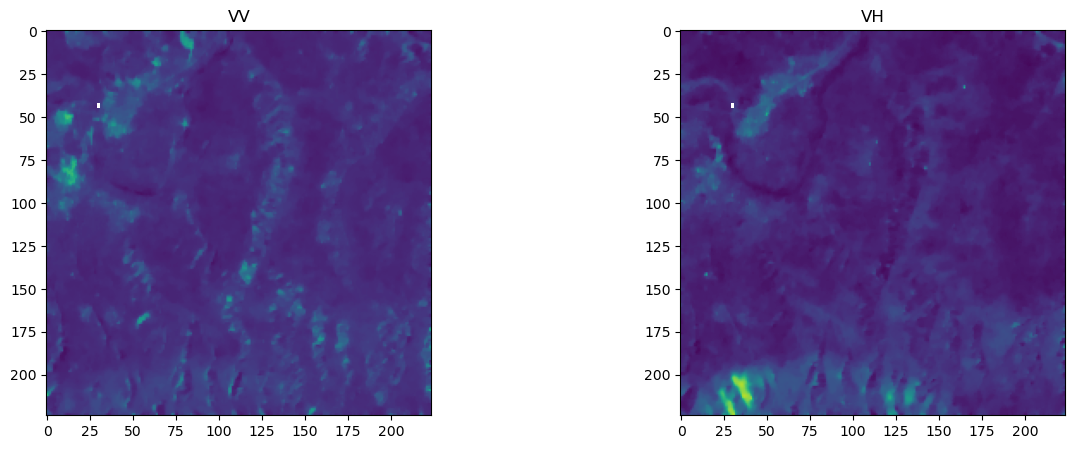

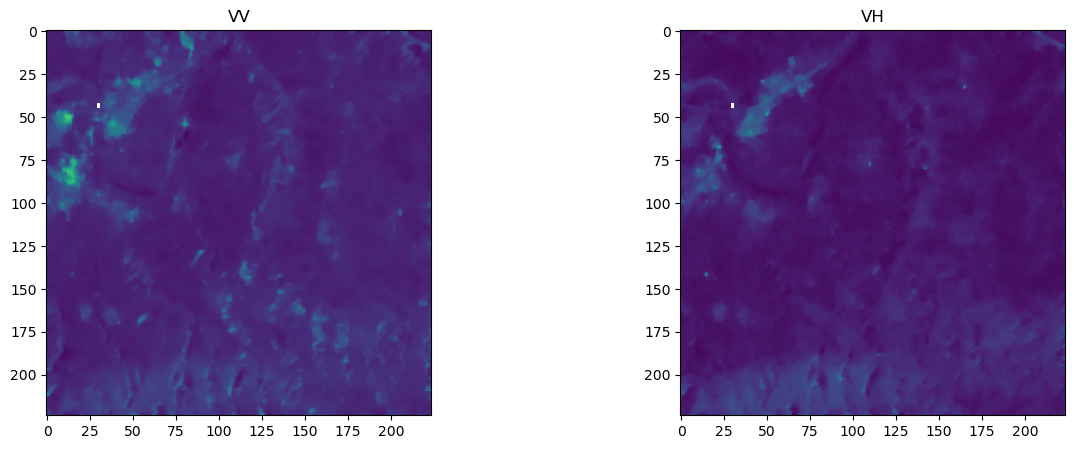

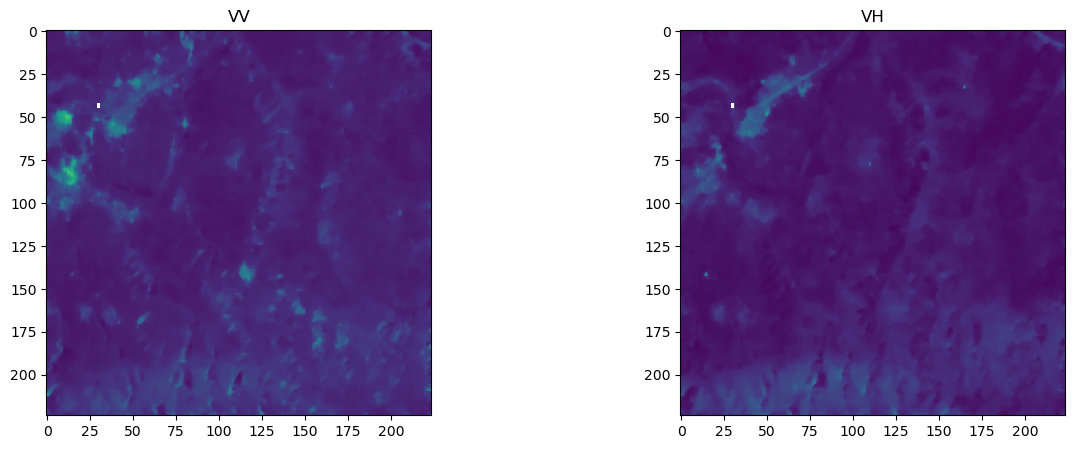

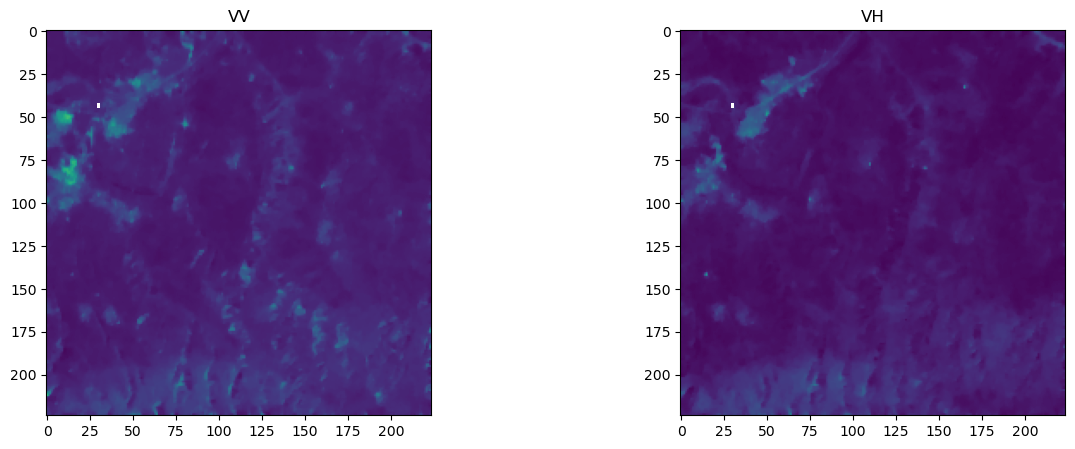

In [31]:
batch_ind = 0

for pre_img_ind in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(pre_imgs[batch_ind, pre_img_ind, 0, ...], vmin=0, vmax=.7)
    axs[0].set_title('VV')
    axs[1].imshow(batch['pre_imgs'][batch_ind, pre_img_ind, 1, ...].cpu().numpy(), vmin=0, vmax=.15)
    axs[1].set_title('VH')
    plt.show()

In [32]:
import pytorch_lightning as pl
from unet import Unet

In [33]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [34]:
model = Unet(backbone='resnet50',
             backbone_kwargs=None,
             backbone_indices=None,
             decoder_use_batchnorm=True,
             decoder_channels=decoder_channels,
             in_chans= seq_dataset.n_pre_imgs * 2)

In [35]:
# model(batch['pre_imgs'].float().flatten(1, 2))

In [49]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [53]:
class UnetAutoencoder(pl.LightningModule):
    def __init__(self, ):
        super().__init__()
        model = Unet(backbone='resnet50',
                     backbone_kwargs=None,
                     backbone_indices=None,
                     decoder_use_batchnorm=True,
                     decoder_channels=decoder_channels,
                     in_chans= seq_dataset.n_pre_imgs * 2)
        self.unet = model

    def training_step(self, batch, batch_idx):
        pre_imgs = batch['pre_imgs']
        post_img = batch['post_img']
        x_hat = self.unet(pre_imgs.float().flatten(1, 2))
        loss = F.mse_loss(x_hat, x)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [54]:
l_model = UnetAutoencoder()

In [55]:
# train model
trainer = pl.Trainer()
trainer.fit(model=l_model, train_dataloaders=train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
Missing logger folder: /Users/cmarshak/bekaert-team/dist-s1-research/marshak/9_unet_autoenc/lightning_logs
Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 141, in zmq.backend.cython._zmq._check_rc
  File "/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_26419/12930177.py", line 3, in <module>
    trainer.fit(model=l_model, train_dataloaders=train_dataloader)
 

NameError: name 'torch' is not defined